In [1]:
import pandas as pd
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from multiprocessing import Pool, cpu_count
from matplotlib import patches, patheffects
import math
from pathlib import Path

from fastai.dataset import *
from fastai.conv_learner import *
from fastai.imports import *
from fastai.structured import *

import pdb

import pickle
from sklearn.model_selection import train_test_split

from IPython.display import FileLink
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [2]:
ddir = "/home/edwin/Datasets/competitions/rsna-pneumonia-detection-challenge"
rsna_path = Path(ddir)

detailed_class_info_csv = pd.read_csv(rsna_path/'stage_1_detailed_class_info.csv')
stage_1_sample_submission_csv = pd.read_csv(rsna_path/'stage_1_sample_submission.csv')
stage_1_train_labels_csv = pd.read_csv(rsna_path/'stage_1_train_labels.csv')

In [3]:
BBOX_CSV_CORNERS = '../tmp/df_sample_bbox_corners.csv'

In [6]:
! ls {rsna_path}

GCP%20Credits%20Request%20Link%20-%20RSNA.txt  stage_1_train_labels.csv.zip
models					       test
sample					       test2
stage_1_detailed_class_info.csv		       test2_png
stage_1_detailed_class_info.csv.zip	       test_png
stage_1_sample_submission.csv		       tmp
stage_1_test_images.zip			       train
stage_1_train_images.zip		       train_png
stage_1_train_labels.csv


In [6]:
f_model=resnet34
sz=224
bs=64

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD)

In [10]:
md_bbox = ImageClassifierData.from_csv(rsna_path, 'train', BBOX_CSV_CORNERS, tfms=tfms, bs=64, suffix='.dcm', 
                                       continuous=True)

In [15]:
df_bbox = pd.read_csv(BBOX_CSV_CORNERS)

In [17]:
stage_1_train_labels_csv[:5]

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [73]:
len(stage_1_train_labels_csv)

28989

In [74]:
len(detailed_class_info_csv)

28989

In [346]:
merged_csv = pd.merge(stage_1_train_labels_csv, detailed_class_info_csv, on='patientId').drop_duplicates()

In [347]:
len(merged_csv)

28989

In [339]:
len(merged_csv.patientId.unique())

25684

In [160]:
len(merged_csv)

35875

In [21]:
rsna_merged_labels = '../tmp/rsna_merged_labels.csv'

In [355]:
merged_csv.to_csv(rsna_merged_labels, index=False)

In [22]:
merged_csv = pd.read_csv(rsna_merged_labels)

In [356]:
merged_csv = pd.read_csv(rsna_merged_labels); merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0,562.0 152.0 818.0 605.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0,323.0 577.0 483.0 681.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0,695.0 575.0 857.0 712.0


In [158]:
len(detailed_class_info_csv)

28989

In [351]:
def bbox_corners(row):
    x = row['x']
    y = row['y']
    width = row['width']
    height = row['height'] 
    if math.isnan(x):
        return "0 0 0 0"
    
    x2 = x + width
    y2 = y + height
    return f"{x} {y} {x2} {y2}"

In [352]:
merged_csv['codes'] = merged_csv['class'].astype('category').cat.codes

In [353]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0


In [354]:
merged_csv['bbox_corners'] = merged_csv.apply(bbox_corners, axis=1)

In [97]:
row = merged_csv.iloc[0]; row

patientId    0004cfab-14fd-4e49-80ba-63a80b6bddd6
x                                             NaN
y                                             NaN
width                                         NaN
height                                        NaN
Target                                          0
class                No Lung Opacity / Not Normal
Name: 0, dtype: object

In [102]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,264.0 152.0 477.0 531.0
6,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,562.0 152.0 818.0 605.0
7,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,562.0 152.0 818.0 605.0
8,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0
9,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,0 0 0 0


In [357]:
sample_csv = merged_csv.sample(n=1000)

In [358]:
sample_csv[['patientId','codes']].to_csv('../tmp/sample_with_class.csv', index=False)

In [359]:
sample_csv[['patientId','bbox_corners']].to_csv('../tmp/sample_with_bbox_corners.csv', index=False)

In [360]:
SAMPLE_LABELS_CSV = pd.read_csv('../tmp/sample_with_class.csv')

In [3]:
SAMPLE_LABELS_CSV_FN = '../tmp/sample_with_class.csv'

In [362]:
SAMPLE_LABELS_BBOX = pd.read_csv('../tmp/sample_with_bbox_corners.csv')

In [4]:
SAMPLE_LABELS_BBOX_FN = '../tmp/sample_with_bbox_corners.csv'

In [46]:
md = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_CSV_FN, bs=64, tfms=tfms_from_model(f_model, sz), suffix='.dcm')
md2 = ImageClassifierData.from_csv(rsna_path, 'train', SAMPLE_LABELS_BBOX_FN, bs=64, tfms=tfms, suffix='.dcm', continuous=True)

In [47]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): 
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [48]:
trn_ds_2 = ConcatLblDataset(md2.trn_ds, md.trn_y)

In [49]:
val_ds_2 = ConcatLblDataset(md2.val_ds, md.val_y)

In [50]:
md2.trn_dl.dataset = trn_ds_2

In [51]:
md2.val_dl.dataset = val_ds_2

In [52]:
x, y = next(iter(md2.trn_dl))

In [23]:
merged_csv[:10]

,patientId,x,y,width,height,Target,class,codes,bbox_corners
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,2,0 0 0 0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,0,264.0 152.0 477.0 531.0
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,0,562.0 152.0 818.0 605.0
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,0 0 0 0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,0,323.0 577.0 483.0 681.0
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,0,695.0 575.0 857.0 712.0


In [26]:
merged_csv['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'], dtype=object)

In [53]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+3),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md2, models)
learn.opt_fn = optim.Adam

In [54]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a 
    # multiplier to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20
def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data
def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)
learn.crit = detn_loss

In [55]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      370.507099 15779.523203



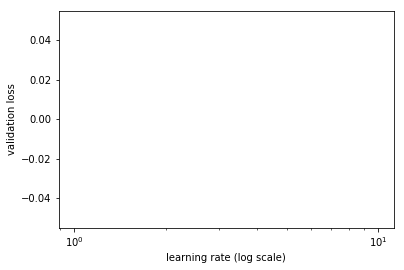

In [56]:
learn.sched.plot()

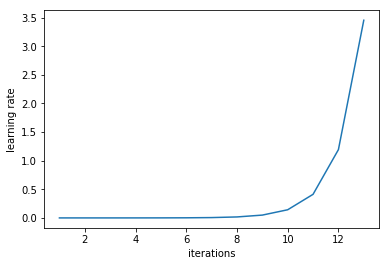

In [57]:
learn.sched.plot_lr()

In [58]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      79.956019  55.280423 
    1      62.585158  42.968682                           



[42.968682403564451]

In [36]:
preds = learn.predict()

In [60]:
np.argmax(preds[0][4:])

0

In [62]:
learn.fit(1e-3, 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      44.192351  41.862801 
    1      42.029206  42.031343                           
    2      40.647221  42.236248                           



[42.236247940063478]

In [69]:
x, y = next(iter(md2.trn_dl))

In [71]:
y

[tensor([[   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [ 125.,   53.,  186.,  156.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [ 140.,   83.,  195.,  148.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [  44.,   90.,   86.,  183.],
         [   0.,    0.,    0.,    0.],
         [ 123.,  115.,  187.,  155.],
         [   0.,    0.,    0.,    0.],
         [   0.,    0.,    0.,    0.],
         [  45.,   60.,   96.,  162.],
         [   0.,    0.,    0.,    0.],
         [ 133.,   77.,  166.,  138.],
         [ 139.,   56.,  194.,  144.],
         [  61.,   35.,  102.,  120.],
         [   0.,    0.,  

In [100]:
y[0][0], y[1][0]

(tensor([ 0.,  0.,  0.,  0.], device='cuda:0'), tensor(2, device='cuda:0'))

In [101]:
pred = to_np(predict_batch(learn.model, x))[0]

In [102]:
np.argmax(pred[4:])

2

In [65]:
learn.predict()

array([[-1.0444 , -1.65458,  0.47193, ...,  2.09249,  0.16974, -1.98635],
       [-4.80953, -4.79547, -4.4712 , ..., -0.15226,  1.16522, -0.72332],
       [-8.05608, -7.88776, -7.59036, ..., -2.31282,  0.5796 ,  1.09416],
       ..., 
       [-7.7425 , -7.7976 , -7.5046 , ..., -2.37977, -0.22292,  1.76629],
       [-3.1485 , -3.3495 , -2.09988, ...,  1.40481,  1.2391 , -2.00364],
       [-3.62908, -4.18973, -2.77805, ...,  0.09739, -0.15211,  0.05921]], dtype=float32)

In [63]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(9408))])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', tensor(128))])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape

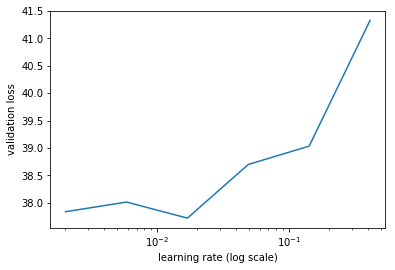

In [105]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [104]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      60.367629  21586.61375



In [106]:
lr = 1e-2

In [ ]:
learn.fit(lr, 5)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|          | 0/13 [00:00<?, ?it/s]